# Análisis de la generación de preguntas

In [1]:
from openai import OpenAI
import os
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import string
import requests

In [2]:
load_dotenv()
apiKey = os.getenv("API_KEY")
client_openai = OpenAI(api_key=apiKey)

size = 250

API_DIR = 'gpt-3.5-turbo'
GENERATE_DIR = 'ft:gpt-3.5-turbo-0125:tfg:pruebapreguntas9:9KUIXy4j'
WIKIPEDIA_DIR = 'https://en.wikipedia.org/w/rest.php/v1/search/page?q='

In [3]:
random_letters = random.choices(string.ascii_lowercase, k=size)
random_letters = [letter for letter in random_letters if letter not in ['w', 'k']]
len(random_letters)

232

### Funciones para generar las preguntas

In [4]:
def generate_words(model, function, temp=1.1, max_tokens = 10, random_letters=random_letters):
	words = []
	for letter in tqdm(random_letters, desc='Generating words'):
		prompt = function(letter)
		response = client_openai.chat.completions.create(
			model=model,
			messages=[
				{'role': 'user', 'content': prompt}
			],
			temperature = temp,
			max_tokens = max_tokens
		)
		words.append((letter, response.choices[0].message.content))
	return words

def generate_desc_words(words, model, function, temp=1.1, max_tokens = 50):
	desc_words = []
	for letter, word in tqdm(words, desc='Generating descriptions'):
		prompt = function(word)
		response = client_openai.chat.completions.create(
			model=model,
			messages=[
				{'role': 'user', 'content': prompt}
			],
			temperature = temp,
			max_tokens = max_tokens
		)
		desc_words.append((letter, word, response.choices[0].message.content))
	return desc_words

### Funciones para medir la calidad de las preguntas

In [5]:
def valid_words(words):
	not_valid =0

	for letter, word in tqdm(words, desc='Validating words'):
		if (letter.lower() not in word.lower()) or (" " in word):
			not_valid += 1
			print(f"Error: \'{word}\' not valid for \'{letter}\'")
		wiki = WIKIPEDIA_DIR + word.lower()
		resp = requests.get(wiki)
		if resp.status_code != 200:
			not_valid += 1
			print(f"Error: \'{word}\' not found in Wikipedia")

	return round((not_valid / len(words))*100, 2)

def valid_descs(descs, function):
	not_accurate =0
	not_valid = 0

	for letter, word, desc in descs:
		if word.lower() in desc.lower():
			not_valid += 1
			break
		promptDesc = function(word, desc)
		response = client_openai.chat.completions.create(
			model=API_DIR,
			messages=[
				{'role': 'user', 'content': promptDesc}
			],
			temperature = 0.5,
			max_tokens = 2
		)
		if response.choices[0].message.content.lower() == 'no':
			not_accurate += 1
			print(f"\'{word}\' - \'{desc}\' not valid")
		elif response.choices[0].message.content.lower() != 'yes':
			print('Error:', response.choices[0].message.content)
	
	not_valid = round((not_valid / len(descs))*100, 2)
	not_accurate = round((not_accurate / len(descs))*100, 2)
	return not_valid, not_accurate

### Funciones para mostrar los gráficos

In [9]:
def generate_words_chart(metrics_api, metrics_model):
    bars_api = 100 - metrics_api
    bars_model = 100 - metrics_model

    plt.figure(figsize=(8, 4))
    bar_width = 0.35
    index = [0, 1]
    plt.bar(index, [bars_api, bars_model], bar_width, label=['API sin entrenar', 'Modelo entrenado'], color=['dodgerblue', 'red'])
    plt.xlabel('Modelo')
    plt.ylabel('Palabras válidas (%)')
    plt.title('Palabras válidas generadas por API y Modelo')
    plt.xticks(index, ['API', 'Modelo'])
    #plt.legend()
    # plt.ylim(0, 100)

    for i, bar in enumerate([bars_api, bars_model]):
        plt.text(i, bar - 25, f'{bar}%', ha='center', color='white')

    plt.tight_layout()

def generate_descs_bar_chart(not_valid_desc_api, not_valid_desc_model, not_acc_desc_api, not_acc_desc_model):
    labels = ['No Válida - API', 'No Válida - Modelo', 'Mala descripción - API', 'Mala descripción - Modelo']
    values = [not_valid_desc_api, not_valid_desc_model, not_acc_desc_api, not_acc_desc_model]

    plt.figure(figsize=(8, 4))
    colors = ['blue', 'red', 'lightblue', 'lightcoral']
    plt.bar(labels, values, color=colors)
    
    plt.xlabel('Modelo')
    plt.ylabel('Porcentaje de descripciones (%)')
    plt.title(f'Distribución de la calidad de las descripciones por modelo')
    plt.ylim(0, 50)

    for i, value in enumerate(values):
        plt.text(i, value + 1, f'{value}%', ha='center', color='black')

    plt.tight_layout()
    plt.show()

## API de OpenAI sin entrenar

Primero se saca una palabra con ese tema, luego una definición para esa palabra.

In [52]:
def promp_question_api(letter):
	return f'Generate only, without any unnecessary message and without punctuation, a word that exists in English, that starts with the letter {letter} that has to do with anything\n'
 
def prompt_desc_api(word):
	return f'Generate a definition of the word "{word}" in 20 words. Include essential information about its meaning and common use. It has to do with anything\n'

def prompt_valid_desc(word, desc):
    return f"Now: Answer yes or no: Does this description: '{desc}' represent the word '{word}'?"

In [53]:
words = generate_words(API_DIR, promp_question_api)
not_valid_api = valid_words(words)

Generating words:   0%|          | 0/225 [00:00<?, ?it/s]

Validating words:  90%|█████████ | 203/225 [02:18<00:16,  1.37it/s]

Error: 'gasoline' not valid for 'b'


Validating words: 100%|██████████| 225/225 [02:33<00:00,  1.47it/s]


In [54]:
descriptions = generate_desc_words(words, API_DIR, prompt_desc_api)
not_valid_desc_api, not_accurate_desc_api = valid_descs(descriptions, prompt_valid_desc)

Generating descriptions: 100%|██████████| 225/225 [03:09<00:00,  1.18it/s]


## Modelo entrenado

In [55]:
def prompt_generate_model(letter):
	return f"Give me a single word, definition and difficulty (Easy, Medium or Hard) that starts with or contains the letter '{letter}' related to anything"

In [56]:
questions = generate_words(GENERATE_DIR, prompt_generate_model, temp=0.8, max_tokens=50)

Generating words:   0%|          | 0/225 [00:00<?, ?it/s]

Generating words: 100%|██████████| 225/225 [02:49<00:00,  1.33it/s]


In [57]:
words_model = [(letter, word.split('|')[0].strip()) for letter, word in questions]
not_valid_model = valid_words(words_model)

descriptions_model = [(letter, word.split('|')[0].strip(), word.split('|')[1].strip()) for letter, word in questions]
not_valid_desc_model, not_accurate_desc_model = valid_descs(descriptions_model, prompt_valid_desc)

Validating words: 100%|██████████| 225/225 [02:30<00:00,  1.49it/s]


## Resultados

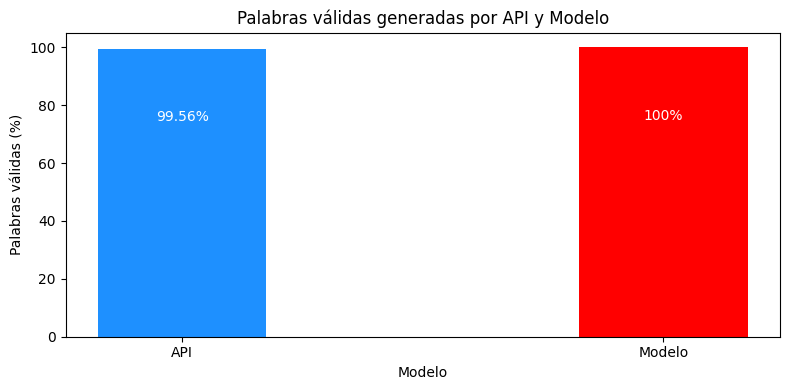

In [11]:
generate_words_chart(not_valid_api, not_valid_model)

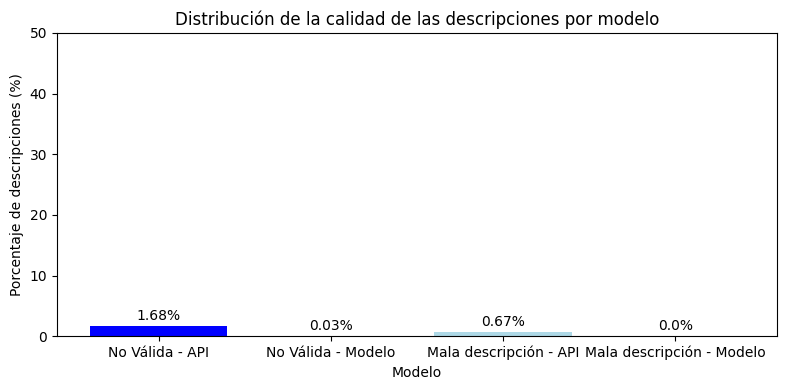

In [70]:
generate_descs_bar_chart(not_valid_desc_api, not_valid_desc_model, not_accurate_desc_api, not_accurate_desc_model)